<a href="https://colab.research.google.com/github/erewl/dsp/blob/main/model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime

In [ ]:
# import libraries
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from lime import lime_image


In [ ]:
# connect to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading

In [ ]:
# define data file paths
ROOT_train = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/train'
ROOT_val = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/val'
ROOT_test = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/test'
knee_data_dir_train = pathlib.Path(ROOT_train)
knee_data_dir_val = pathlib.Path(ROOT_val)
knee_data_dir_test = pathlib.Path(ROOT_test)

In [ ]:
# define some hyperparameters
batch_size = 32
img_height = 224
img_width = 224

# if set to True, image data will be augmented during training (rescaling, shear, zoom, flip)
data_augmentation = False

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
if not data_augmentation:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      knee_data_dir_train,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

else:
    train_ds = train_datagen.flow_from_directory(
      knee_data_dir_train,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse'
      # , color_mode='grayscale'
      )

Found 5778 files belonging to 5 classes.


In [ ]:
if not data_augmentation:
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      knee_data_dir_val,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

else:
    val_ds = train_datagen.flow_from_directory(
      knee_data_dir_val,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse'
      # , color_mode='grayscale'
      )

Found 826 files belonging to 5 classes.


In [ ]:
if not data_augmentation:
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      knee_data_dir_test,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
else: 
    test_ds = test_datagen.flow_from_directory(
      knee_data_dir_test,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse'
      # , color_mode='grayscale'
      )

Found 1656 files belonging to 5 classes.


In [ ]:
def show_k_images(k):
  plt.figure(figsize=(10, 10))
  for images, labels in test_ds.take(1):
    for i in range(k):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

### Keras Model Training

In [ ]:
# load DenseNet169

model = tf.keras.applications.DenseNet169(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling='max',
    classes=5,
)

In [ ]:
# load DenseNet201

model = tf.keras.applications.DenseNet201(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=5,
)

In [ ]:
# compile the model

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
  )

In [1]:
# define callbacks

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1, min_delta=1e-4)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# fit the model

h = model201.fit_generator(train_ds, 
              validation_data = val_ds,
              # validation_steps = 826 // batch_size, 
              epochs = 200, verbose = 1, 
              callbacks=[early_stop, lr_schedule]
              )

In [ ]:
model.save('/content/drive/MyDrive/DSP-H3-Quin/model_4.h5')

In [ ]:
# model 1: early stopping, 200 epochs, batch size 32, avg pooling; train accuracy 0.62; overfitting a lot
# model 2: early stopping + LR scheduler, 200 epochs, bs 32, avg pooling; train accuracy 0.73; overfitting (but less)
# model 3: early stopping + LR scheduler, 200 epochs, bs 32, max pooling; train accuracy 0.40; overfitting a lot
# model 4: D201, early stopping + LR scheduler, 200 epochs, bs 32, avg pooling; train accuracy

In [ ]:
# plt.plot(h.history['accuracy'])
# plt.plot(h.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

### Load Model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/DSP-H3-Quin/model_2.h5')

In [ ]:
score = loaded_model.evaluate_generator(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss:  1.3190611600875854
Test accuracy:  0.5314009785652161


### XAI

#### LIME

In [ ]:
class_names = test_ds.class_names

In [ ]:
# l = []
# yy = []
# for images, labels in test_ds.take(1):
#   for i in range(2):
#     l.append(images[i].numpy())
#     yy.append(class_names[labels[i]])

In [ ]:
# load test image

image_test = cv2.imread('/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/auto_test/4/9012867_1.png')
image_test = image_test.reshape((1, 224, 224, 3))

In [2]:
def plot_image(img):
  plt.imshow(img.astype("uint8"))

In [ ]:
def plot_lime_explanations(explainer, model, img, top_labels=3, hide_color=0, num_samples=1000):
  pass

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(image_test.astype('uint8'), loaded_model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
pred = loaded_model.predict(image_test.astype('uint8'))
print(np.argmax(pred[0]))

In [ ]:
# print("Prediction: ", explanation.top_labels[0])

(-0.5, 223.5, 223.5, -0.5)

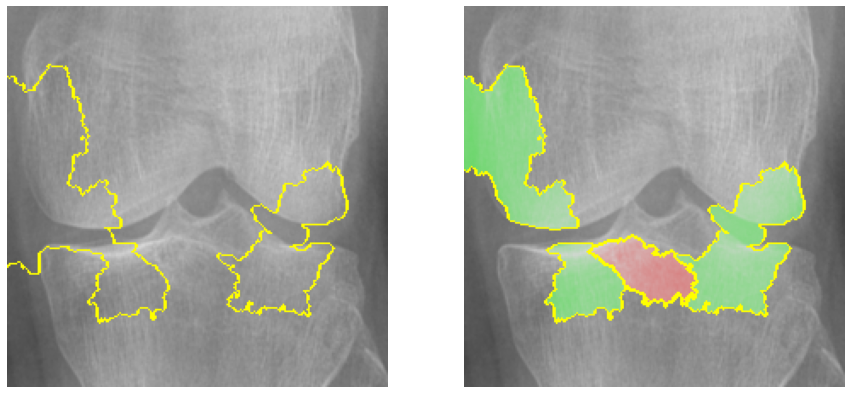

In [ ]:
# plot image with LIME mask

from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=6, hide_rest=False)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=6, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

#### GradCam.py

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

#### GradCam Impl

In [ ]:
image_test = cv2.imread('/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/auto_test/4/9012867_1.png')
image_test = image_test.reshape((1, 224, 224, 3))

In [ ]:
# pred_ = loaded_model.predict(image_test.astype('uint8'))
# print(np.argmax(pred_[0]))

In [ ]:
i = np.argmax(pred[0])

In [ ]:
# get layer names

for idx in range(len(loaded_model.layers)):
  print(loaded_model.get_layer(index = idx).name)

In [ ]:
# image = cv2.imread('/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/auto_test/4/9012867_1.png')
# image = cv2.resize(image, (224, 224))

# image_re = image.reshape((1, 224, 224, 3))

In [ ]:
print(image.shape, image_re.shape)

(224, 224, 3) (1, 224, 224, 3)


In [ ]:
# conv5_block32_concat
icam = GradCAM(loaded_model, i, 'conv5_block32_concat') 
heatmap = icam.compute_heatmap(image_test)
heatmap = cv2.resize(heatmap, (224, 224))

In [ ]:
print(heatmap.shape, image.shape, image_re.shape)

(224, 224) (224, 224, 3) (1, 224, 224, 3)


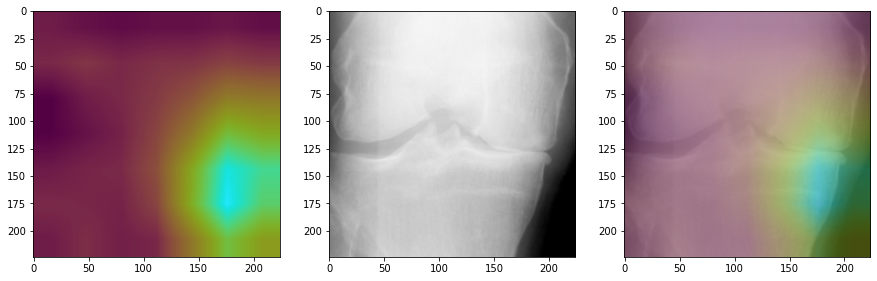

In [ ]:
(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3, figsize=(15,15))

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)


### PyTorch Pre-trained Model (ignore this part for now)

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
ROOT_train = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/train'
ROOT_val = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/val'
ROOT_test = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/test'
ROOT_auto_test = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/auto_test'

In [ ]:
model = torch.load('/content/drive/MyDrive/DSP-H3-Quin/model_stuff/densenet169/densenet-169-SGD-0/6-0.665-0.668-0.522.pth')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torchvision.models.densenet.DenseNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or 

In [ ]:
# model.eval()

In [ ]:
test_dataset = ImageFolder(ROOT_auto_test, transform=ToTensor())

In [ ]:
classes = test_dataset.classes

Label:  0 (0)


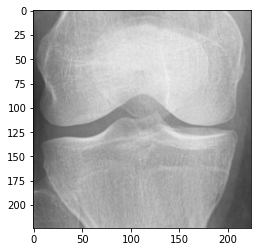

In [ ]:
def show_example(img, label):
    print('Label: ', test_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
show_example(*test_dataset[0])

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(224),                    #[2]
 transforms.CenterCrop(224),                #[3]
#  transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]
 )])


In [ ]:
img, label = test_dataset[0]

In [ ]:
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)

In [ ]:
model2 = torch.load('/content/drive/MyDrive/DSP-H3-Quin/model_stuff/vgg16/vgg-16-SGD-0/5-0.64-0.671-0.585.pth')

In [ ]:
model2.eval()

In [ ]:
output = model2(batch_t)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

AttributeError: ignored

In [ ]:
out = model2(batch_t)

AttributeError: ignored

In [ ]:
classes = [test_dataset.classes] # change to labels probably
_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 10
print(labels[index[0]], percentage[index[0]].item())

NameError: ignored

In [ ]:
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]